<a href="https://colab.research.google.com/github/nirmit27/ml-notebooks/blob/main/ML/KMeans_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Means** Clustering

### Importing the necessary modules

In [ ]:
!pip install feature-engine
!pip install kneed
!pip install -U kaleido

In [ ]:
import warnings

warnings.filterwarnings(
    action="ignore",
    message=r"When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas\. Pass `\(name,\)` instead of `name` to silence this warning\.",
    category=FutureWarning,
    module=r"plotly\.express\._core",
)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Setting the global style for matplotlib
plt.style.use("seaborn-v0_8")

import kaleido
import plotly.express as px
import plotly.graph_objects as go

from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler

import scipy.stats as stats
from kneed import KneeLocator
from sklearn.cluster import KMeans

### Importing the dataset

In [ ]:
df = pd.read_excel(r"/content/University.xlsx")
df.head()

,Univ,State,SAT,Top10,Accept,SFRatio,Expenses,GradRate
0,Brown,RI,1310,89,22,13,22704,94
1,CalTech,CA,1415,100,25,6,63575,81
2,CMU,PA,1260,62,59,9,25026,72
3,Columbia,NY,1310,76,24,12,31510,88
4,Cornell,NY,1280,83,33,13,21864,90


## Data **Preprocessing**

#### Information about the columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Univ      25 non-null     object
 1   State     25 non-null     object
 2   SAT       25 non-null     int64 
 3   Top10     25 non-null     int64 
 4   Accept    25 non-null     int64 
 5   SFRatio   25 non-null     int64 
 6   Expenses  25 non-null     int64 
 7   GradRate  25 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 1.7+ KB


#### Numerical features

In [ ]:
df_num = df.select_dtypes(exclude="object").astype('float')
df_num.head()

,SAT,Top10,Accept,SFRatio,Expenses,GradRate
0,1310.0,89.0,22.0,13.0,22704.0,94.0
1,1415.0,100.0,25.0,6.0,63575.0,81.0
2,1260.0,62.0,59.0,9.0,25026.0,72.0
3,1310.0,76.0,24.0,12.0,31510.0,88.0
4,1280.0,83.0,33.0,13.0,21864.0,90.0


#### Categorical features

In [ ]:
df_cat = df.select_dtypes(include="object")
df_cat.head()

,Univ,State
0,Brown,RI
1,CalTech,CA
2,CMU,PA
3,Columbia,NY
4,Cornell,NY


#### Checking for **missing** values

In [ ]:
df.isna().sum()

,0
Univ,0
State,0
SAT,0
Top10,0
Accept,0
SFRatio,0
Expenses,0
GradRate,0


> There is **no** need for missing value imputation for the given dataset.

#### Outlier visualization
> before **winsorization**

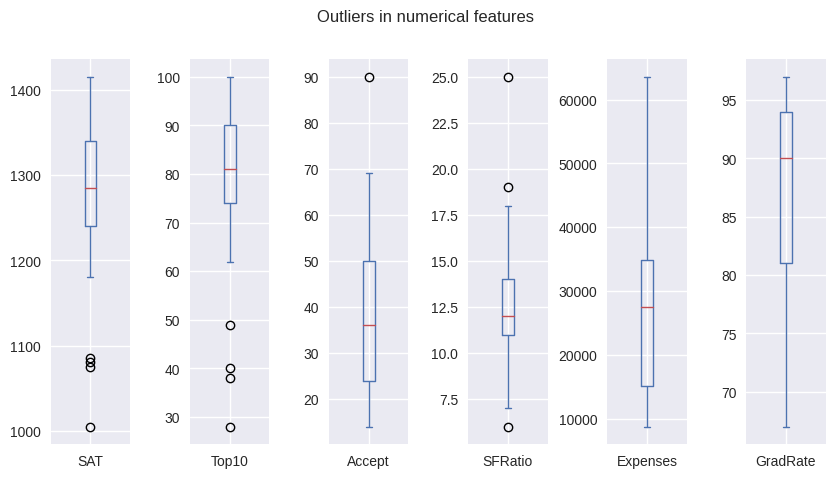

In [ ]:
df_num.plot(kind='box', subplots=True, figsize=(10, 5), sharey=False, title="Outliers in numerical features")
plt.subplots_adjust(wspace=0.75)
plt.show()

> There are outliers present in every numerical column except for `Expenses` and `GradRate`.

#### Winsorization
> for the treatment of **outliers**, using the `IQR` capping method

In [ ]:
def winsorize(column: str):
  winsorizer = Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=[column])
  df_num[column] = winsorizer.fit_transform(df_num[[column]])

In [ ]:
for column in df_num.columns:
  winsorize(df_num[column].name)

#### Outlier visualization
> after **winsorization**

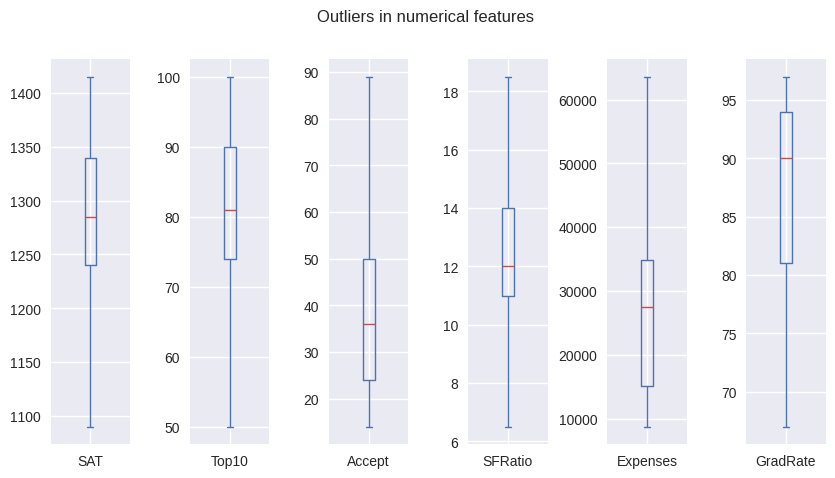

In [ ]:
df_num.plot(kind='box', subplots=True, figsize=(10, 5), sharey=False, title="Outliers in numerical features")
plt.subplots_adjust(wspace=0.75)
plt.show()

### Dummy variables
> generating **dummy** variable column for the categorical features

#### Unique values

In [ ]:
df_cat['State'].unique(), df_cat['Univ'].unique()

(array(['RI', 'CA', 'PA', 'NY', 'NH', 'NC', 'DC', 'MA', 'MD', 'IL', 'IN',
        'NJ', 'TX', 'MI', 'VA', 'WI', 'CT'], dtype=object),
 array(['Brown', 'CalTech', 'CMU', 'Columbia', 'Cornell', 'Dartmouth',
        'Duke', 'Georgetown', 'Harvard', 'JohnsHopkins', 'MIT',
        'Northwestern', 'NotreDame', 'PennState', 'Princeton', 'Purdue',
        'Stanford', 'TexasA&M', 'UCBerkeley', 'UChicago', 'UMichigan',
        'UPenn', 'UVA', 'UWisconsin', 'Yale'], dtype=object))

> Taking into consideration the `State` column for dummy variables since it will be used for clustering based on geographical location.

In [ ]:
df_cat = pd.get_dummies(df_cat, columns=['State'], drop_first=True, dtype='int64')
df_cat.head()

,Univ,State_CT,State_DC,State_IL,State_IN,State_MA,State_MD,State_MI,State_NC,State_NH,State_NJ,State_NY,State_PA,State_RI,State_TX,State_VA,State_WI
0,Brown,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,CalTech,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CMU,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Columbia,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,Cornell,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## **EDA**

### Univariate analysis
> plotting the distribution of numerical columns using **KDE** plots

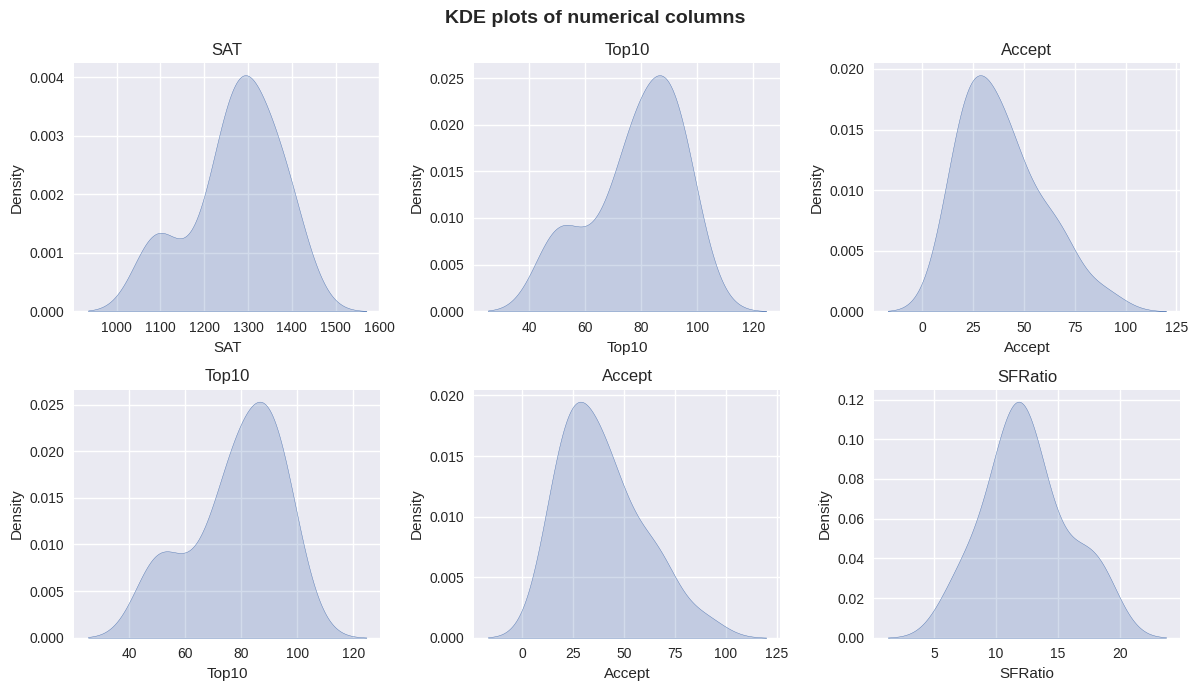

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle("KDE plots of numerical columns", fontweight='bold', fontsize=14)

for i in range(2):
  for j in range(3):
    sns.kdeplot(df_num, x=df_num.columns[i + j], fill=True, ax=axs[i][j])
    axs[i][j].set_title(df_num.columns[i + j])

plt.tight_layout()
plt.show()

#### Univariate Normality
> checking the **univariate normality** of the numerical columns using **Q-Q** plot

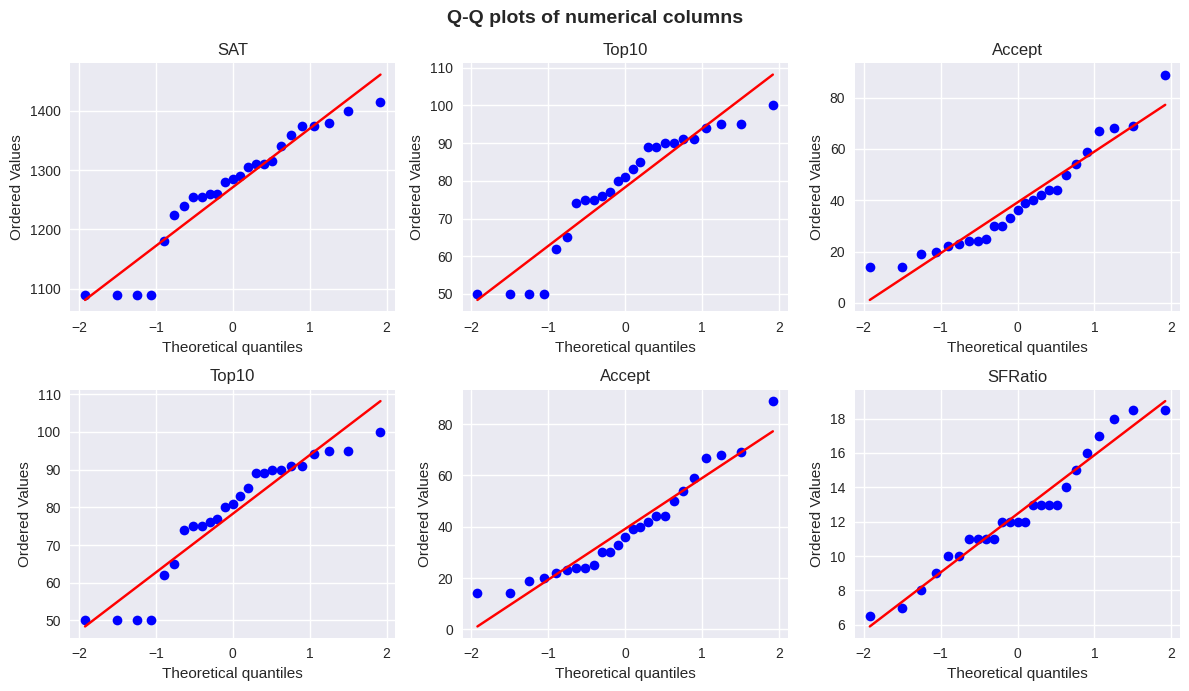

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle("Q-Q plots of numerical columns", fontweight='bold', fontsize=14)

for i in range(2):
  for j in range(3):
    stats.probplot(df_num[df_num.columns[i + j]], dist='norm', plot=axs[i][j])
    axs[i][j].set_title(df_num.columns[i + j])

plt.tight_layout()
plt.show()

#### **Bivariate** analysis

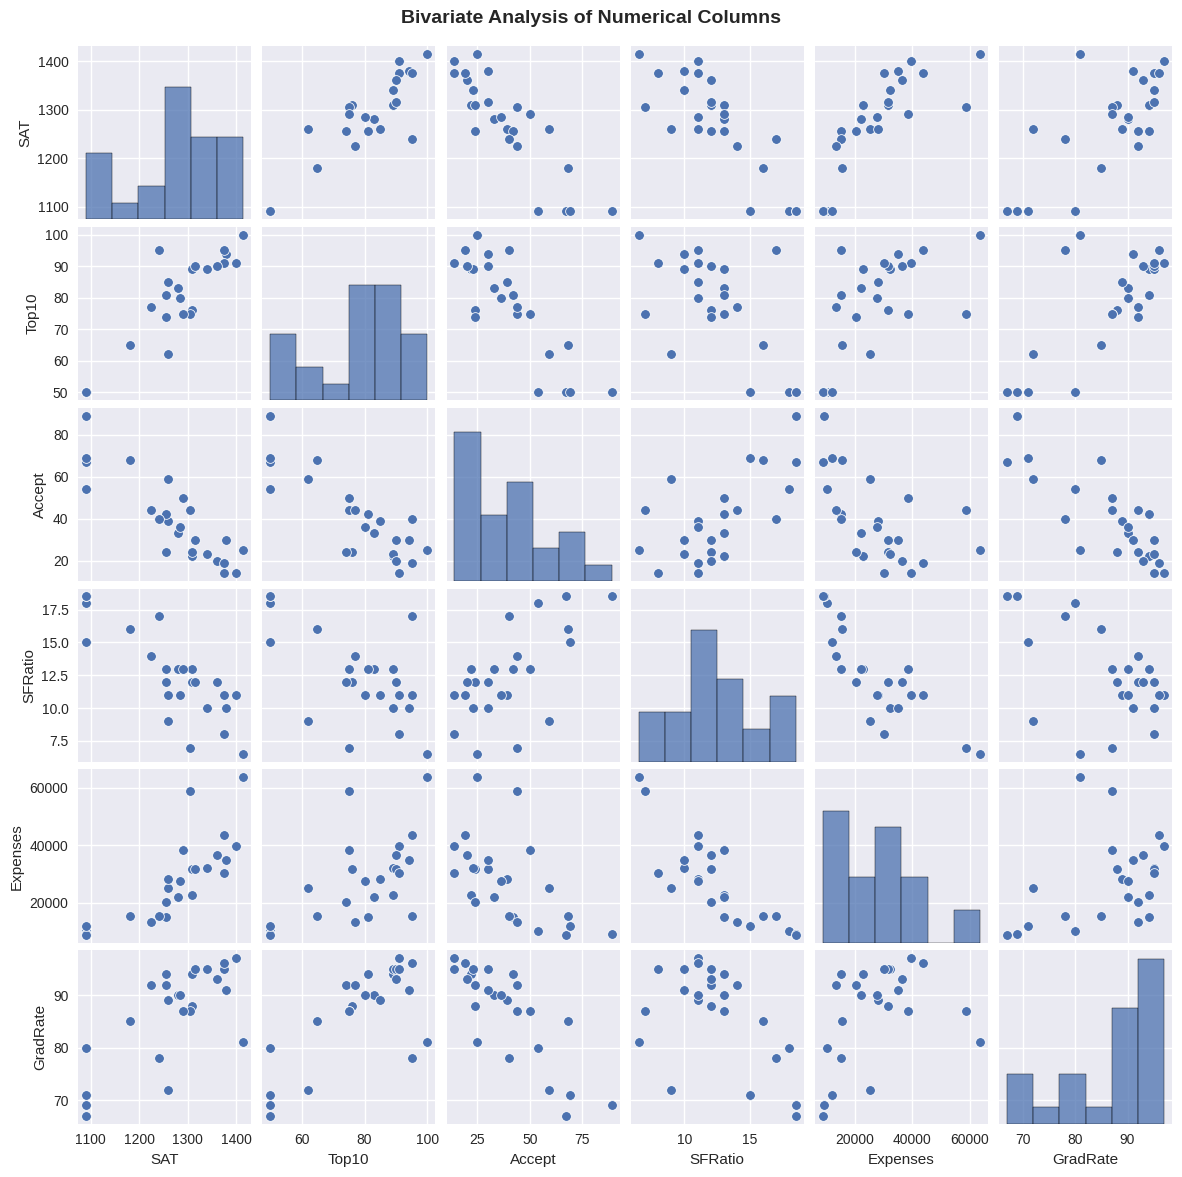

In [ ]:
pairplot = sns.pairplot(df_num, height=2, aspect=1)

pairplot.fig.suptitle("Bivariate Analysis of Numerical Columns", fontsize=14, fontweight='bold')
pairplot.fig.subplots_adjust(top=0.95)

plt.show()

#### **Correlational** analysis
> analysing the `Pearson` correlation between the numerical features

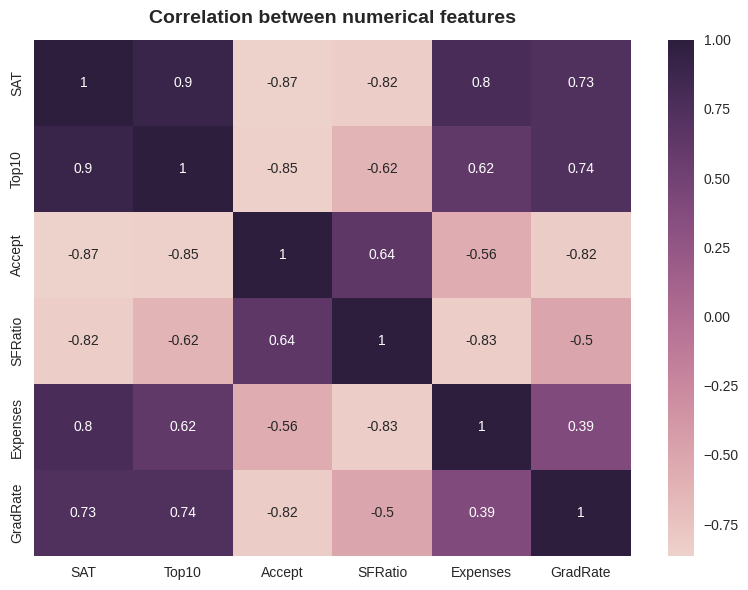

In [ ]:
corr = df_num.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

plt.title("Correlation between numerical features", fontsize=14, fontweight='bold', pad=12)

plt.tight_layout()
plt.show()

> There is **high** level of correlation between between `Top10` - `SAT` (0.9), `SAT` - `Expenses` (0.8), `Top10` - `GradRate` (0.74) and `GradRate` - `SAT` (0.73) column pairs.

#### **Concatenation**
> Concatenating the **numerical** and **categorical** columns

In [ ]:
df_final = pd.concat([df_cat, df_num], axis=1)

df_final.head()

,Univ,State_CT,State_DC,State_IL,State_IN,State_MA,State_MD,State_MI,State_NC,State_NH,...,State_RI,State_TX,State_VA,State_WI,SAT,Top10,Accept,SFRatio,Expenses,GradRate
0,Brown,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1310.0,89.0,22.0,13.0,22704.0,94.0
1,CalTech,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1415.0,100.0,25.0,6.5,63575.0,81.0
2,CMU,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1260.0,62.0,59.0,9.0,25026.0,72.0
3,Columbia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1310.0,76.0,24.0,12.0,31510.0,88.0
4,Cornell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1280.0,83.0,33.0,13.0,21864.0,90.0


### **Min-Max** scaling
> scaling the numerical features in the range `[0, 1]`

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_final.iloc[:, 1:] = scaler.fit_transform(df_final.iloc[:, 1:])

df_final.head()

,Univ,State_CT,State_DC,State_IL,State_IN,State_MA,State_MD,State_MI,State_NC,State_NH,...,State_RI,State_TX,State_VA,State_WI,SAT,Top10,Accept,SFRatio,Expenses,GradRate
0,Brown,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0.676923,0.78,0.106667,0.541667,0.255144,0.900000
1,CalTech,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.000000,1.00,0.146667,0.000000,1.000000,0.466667
2,CMU,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.523077,0.24,0.600000,0.208333,0.297461,0.166667
3,Columbia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.676923,0.52,0.133333,0.458333,0.415629,0.700000
4,Cornell,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.584615,0.66,0.253333,0.541667,0.239835,0.766667


#### **Final** dataset

In [ ]:
df_final.describe()

,State_CT,State_DC,State_IL,State_IN,State_MA,State_MD,State_MI,State_NC,State_NH,State_NJ,...,State_RI,State_TX,State_VA,State_WI,SAT,Top10,Accept,SFRatio,Expenses,GradRate
count,25.00,25.00,25.000000,25.000000,25.000000,25.00,25.00,25.00,25.00,25.00,...,25.00,25.00,25.00,25.00,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.04,0.04,0.080000,0.080000,0.080000,0.04,0.04,0.04,0.04,0.04,...,0.04,0.04,0.04,0.04,0.556923,0.565600,0.335467,0.496667,0.340508,0.657333
std,0.20,0.20,0.276887,0.276887,0.276887,0.20,0.20,0.20,0.20,0.20,...,0.20,0.20,0.20,0.20,0.303497,0.312811,0.261610,0.277149,0.262887,0.301926
min,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.461538,0.480000,0.133333,0.375000,0.117293,0.466667
50%,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.600000,0.620000,0.293333,0.458333,0.343515,0.766667
75%,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.769231,0.800000,0.480000,0.625000,0.476864,0.900000
max,1.00,1.00,1.000000,1.000000,1.000000,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Cluster** modelling

#### Number of clusters
> determining the **number** of clusters using `elbow` plot

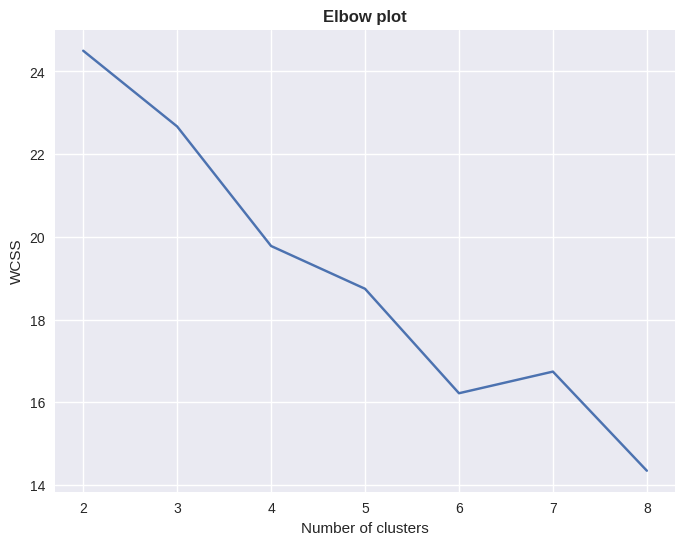

In [ ]:
wcss = []
clusters = list(range(2, 9))

for i in range(2, 9):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(df_final.iloc[:, 1:])
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(clusters, wcss)

plt.title("Elbow plot", fontsize=12, fontweight='bold')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

plt.show()

#### Locating the **knee** point
> using the `KneeLocator` object

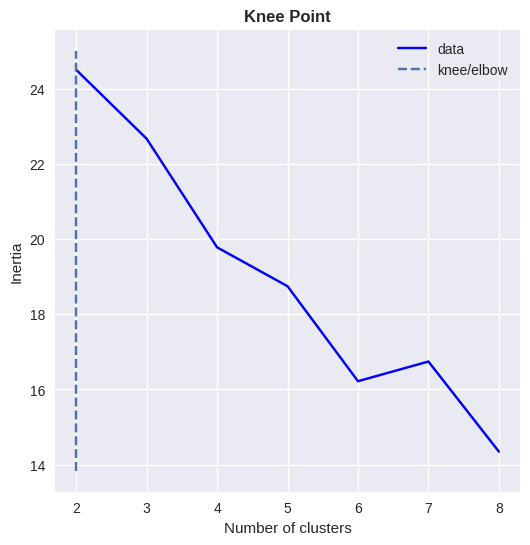

In [ ]:
kl = KneeLocator(clusters, wcss, curve="concave", direction="increasing")
kl.plot_knee()

plt.title("Knee Point", fontweight='bold')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.show()

> Hence, the number of clusters should be **2**.

#### Finding out the clusters
> clustering the universities based on their data

In [ ]:
model = KMeans(n_clusters=2, random_state=27)
y_means = model.fit_predict(df_final.iloc[:, 1:])

y_means

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0], dtype=int32)

#### Cluster labels
> obtaining the labels of the universities based on their assigned cluster

| Cluster | Label |
| ------- | ----- |
| Top Univeristy | 0 |
| Mid University | 1 |

In [ ]:
df['Cluster'] = y_means
df.iloc[:, [0, -1]].head()

,Univ,Cluster
0,Brown,0
1,CalTech,0
2,CMU,1
3,Columbia,0
4,Cornell,0


#### Top and Mediocre universities
> obtaining their names

In [ ]:
top_univ = df[y_means == 0]["Univ"].values
mid_univ = df[y_means == 1]["Univ"].values

top_univ, mid_univ

(array(['Brown', 'CalTech', 'Columbia', 'Cornell', 'Dartmouth', 'Duke',
        'Georgetown', 'Harvard', 'JohnsHopkins', 'MIT', 'Northwestern',
        'Princeton', 'Stanford', 'UChicago', 'UPenn', 'Yale'], dtype=object),
 array(['CMU', 'NotreDame', 'PennState', 'Purdue', 'TexasA&M',
        'UCBerkeley', 'UMichigan', 'UVA', 'UWisconsin'], dtype=object))

In [ ]:
df['Cluster'] = df['Cluster'].astype('object')
df['Cluster'] = df['Cluster'].map({0: "Top Univ.", 1: "Mid Univ."})

df['Cluster'].head()

,Cluster
0,Top Univ.
1,Top Univ.
2,Mid Univ.
3,Top Univ.
4,Top Univ.


## **3-D** Scatter plot
> plotting the result of clustering on the basis of `top 3` most relevant features obtained from the [correlational matrix](#scrollTo=PFZske7N9QNu&line=3&uniqifier=1)

In [ ]:
top_features = ['Top10', 'SAT', 'Accept', 'Cluster']
df[top_features].head()

,Top10,SAT,Accept,Cluster
0,89,1310,22,Top Univ.
1,100,1415,25,Top Univ.
2,62,1260,59,Mid Univ.
3,76,1310,24,Top Univ.
4,83,1280,33,Top Univ.


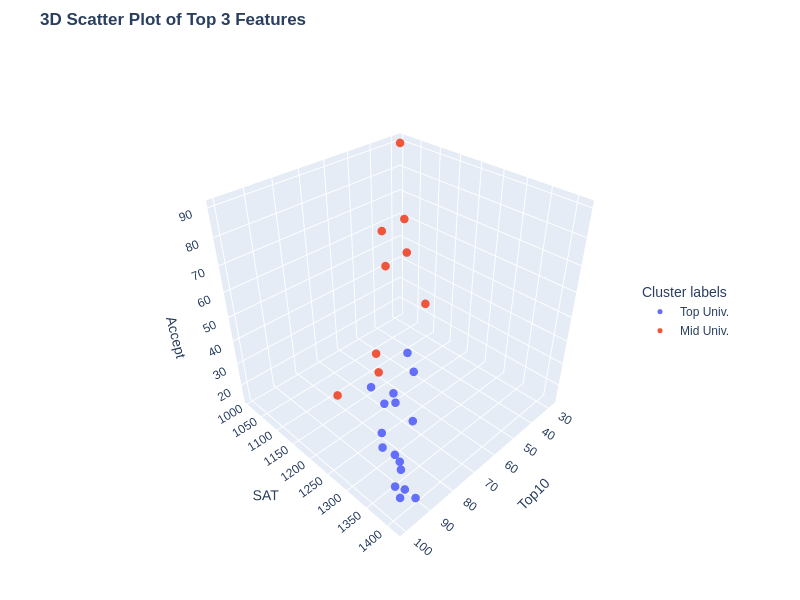

In [ ]:
data = df[top_features]

fig = go.Figure()
fig = px.scatter_3d(data, x='Top10', y='SAT', z='Accept',
                    color='Cluster',
                    title="<b>3D Scatter Plot of Top 3 Features</b>",)

fig.update_traces(marker=dict(size=5))

fig.update_layout(
    margin=dict(l=0, r=0, b=25, t=50),
    width=800,
    height=600,
    scene=dict(
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='auto'
    ),
    legend=dict(
        x=0.8,
        y=0.5,
        orientation='v',
        title='Cluster labels',
        title_font=dict(size=14),
        font=dict(size=12),
  ))

fig.show("png")